In [4]:
# !pip install ucimlrepo

In [5]:

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 
  
# variable information 
print(default_of_credit_card_clients.variables) 

# https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

df = pd.concat([X, y], axis=1)

   name     role     type      demographic                 description units  \
0    ID       ID  Integer             None                        None  None   
1    X1  Feature  Integer             None                   LIMIT_BAL  None   
2    X2  Feature  Integer              Sex                         SEX  None   
3    X3  Feature  Integer  Education Level                   EDUCATION  None   
4    X4  Feature  Integer   Marital Status                    MARRIAGE  None   
5    X5  Feature  Integer              Age                         AGE  None   
6    X6  Feature  Integer             None                       PAY_0  None   
7    X7  Feature  Integer             None                       PAY_2  None   
8    X8  Feature  Integer             None                       PAY_3  None   
9    X9  Feature  Integer             None                       PAY_4  None   
10  X10  Feature  Integer             None                       PAY_5  None   
11  X11  Feature  Integer             No

## 1. Logistic Regression Objective Function

### Logistic Regression Model
Logistic Regression models the probability that a binary outcome equals 1. For a data point \($x_i$\):

$
P(y_i = 1 \mid x_i, w) = \sigma(w^\top x_i)
$

where the sigmoid function is:

$
\sigma(z) = \frac{1}{1 + e^{-z}}
$

Here, \(w\) is the vector of model parameters.


### Maximum Likelihood Estimation

Each label \($y_i \in \{0,1\}$\) is assumed to follow a Bernoulli distribution. The likelihood of the dataset is:

$
P(\mathbf{y} \mid X, w) = \prod_{i=1}^{n} p_i^{y_i} (1 - p_i)^{1 - y_i}
$

Taking the log-likelihood:

$
\ell(w) = \sum_{i=1}^{n} \left[y_i \log(p_i) + (1 - y_i)\log(1 - p_i)\right]
$

Substituting \($p_i = \sigma(w^\top x_i)$\) and simplifying gives:

$
\ell(w) = \sum_{i=1}^{n} \left[y_i (w^\top x_i) - \log(1 + e^{w^\top x_i})\right]
$

The MLE objective is to maximize this log-likelihood.


### MAP vs MLE

MAP estimation extends MLE by adding a prior distribution over the model parameters:


- **MLE** uses only the data likelihood.
- **MAP** incorporates prior beliefs and helps reduce overfitting.

MAP is commonly used in practice because it improves generalization, especially when features are correlated or numerous.

“Lecture 6: Logistic Regression.” Cornell.edu, 2026, www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/lecturenote06.html. Accessed 20 Jan. 2026.


## 2. Machine Learning Problem Definition

### Problem Description
The goal is to predict whether a credit card client will default on their payment. The target variable is binary:
- \(y = 1\): default
- \(y = 0\): no default

This is a binary classification problem.


### Why Logistic Regression?
Logistic Regression is well-suited because:
1. It directly models the probability of default, which is important in credit risk analysis.
2. The model is interpretable, allowing financial institutions to understand feature impacts.
3. It is efficient, convex, and performs well as a baseline classifier.


### Comparison to Another Linear Model
Compared to a linear Support Vector Machine:
- Logistic Regression outputs probabilities directly.
- Linear SVM focuses on maximizing the margin and does not naturally produce probabilities.
- Logistic Regression is often preferred when probability estimates are required.


Cortes, C., & Vapnik, V. (1995). *Support-vector networks*. **Machine Learning, 20**(3), 273–297. https://doi.org/10.1007/BF00994018



## 3. Dataset and Model Assumptions

### Mapping Dataset to the Model
- Each client corresponds to one data point \($x_i$\)
- The feature vector includes:
  - Credit amount
  - Demographic variables (age, sex, education, marital status)
  - Payment history
  - Bill amounts
  - Previous payments
- The target variable \($y_i$\) represents default payment status

The dataset contains 30,000 instances and 23 features.


### Assumptions
1. Observations are independent and identically distributed.
2. The log-odds of default are a linear function of the input features.
3. Categorical variables are assumed to be properly encoded.
4. The dataset has no missing values.


In [7]:
df.info()

df.describe()

df["Y"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  Y       300

,proportion
Y,
0,0.7788
1,0.2212


In [8]:
# drop target variable
X_vif = df.drop(columns=["Y"])

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif)

# calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [
    variance_inflation_factor(X_scaled, i)
    for i in range(X_scaled.shape[1])
]

vif_df.sort_values(by="VIF", ascending=False)


,feature,VIF
12,X13,25.864853
15,X16,24.996689
13,X14,21.775684
14,X15,20.346841
16,X17,15.024784
11,X12,14.032744
9,X10,4.725098
8,X9,4.287408
7,X8,3.657496
10,X11,3.256188


In [9]:
high_vif_features = vif_df[vif_df["VIF"] > 10]["feature"].tolist()

high_vif_features


['X12', 'X13', 'X14', 'X15', 'X16', 'X17']

In [10]:
# create average bill amount feature
df["AVG_BILL_AMT"] = df[
    ["X12", "X13", "X14", "X15", "X16", "X17"]
].mean(axis=1)

# drop original bill amount features
df_reduced = df.drop(columns=["X12", "X13", "X14", "X15", "X16", "X17"])


In [11]:
# recompute VIF with new feature

X_final = df_reduced.drop(columns=["Y"])

X_scaled = StandardScaler().fit_transform(X_final)

vif_final = pd.DataFrame()
vif_final["feature"] = X_final.columns
vif_final["VIF"] = [
    variance_inflation_factor(X_scaled, i)
    for i in range(X_scaled.shape[1])
]

vif_final.sort_values(by="VIF", ascending=False)


,feature,VIF
9,X10,4.703742
8,X9,4.275546
7,X8,3.636673
10,X11,3.204568
6,X7,3.150120
5,X6,1.918826
0,X1,1.552430
17,AVG_BILL_AMT,1.458119
4,X5,1.275063
3,X4,1.229801


### Multicollinearity Analysis and Handling

VIF was used to assess multicollinearity among the features. Initial VIF results showed a lot of multicollinearity among the monthly bill amount variables (X12–X17), with VIF values exceeding 10, indicating strong linear dependence across these features.

To address this issue, the monthly bill amount variables were aggregated into a single feature, AVG_BILL_AMT, representing the average bill statement across six months. The original bill amount variables were then removed from the dataset.

After this transformation, VIF was recomputed. All remaining features exhibited VIF values below 5, indicating that multicollinearity had been effectively mitigated.


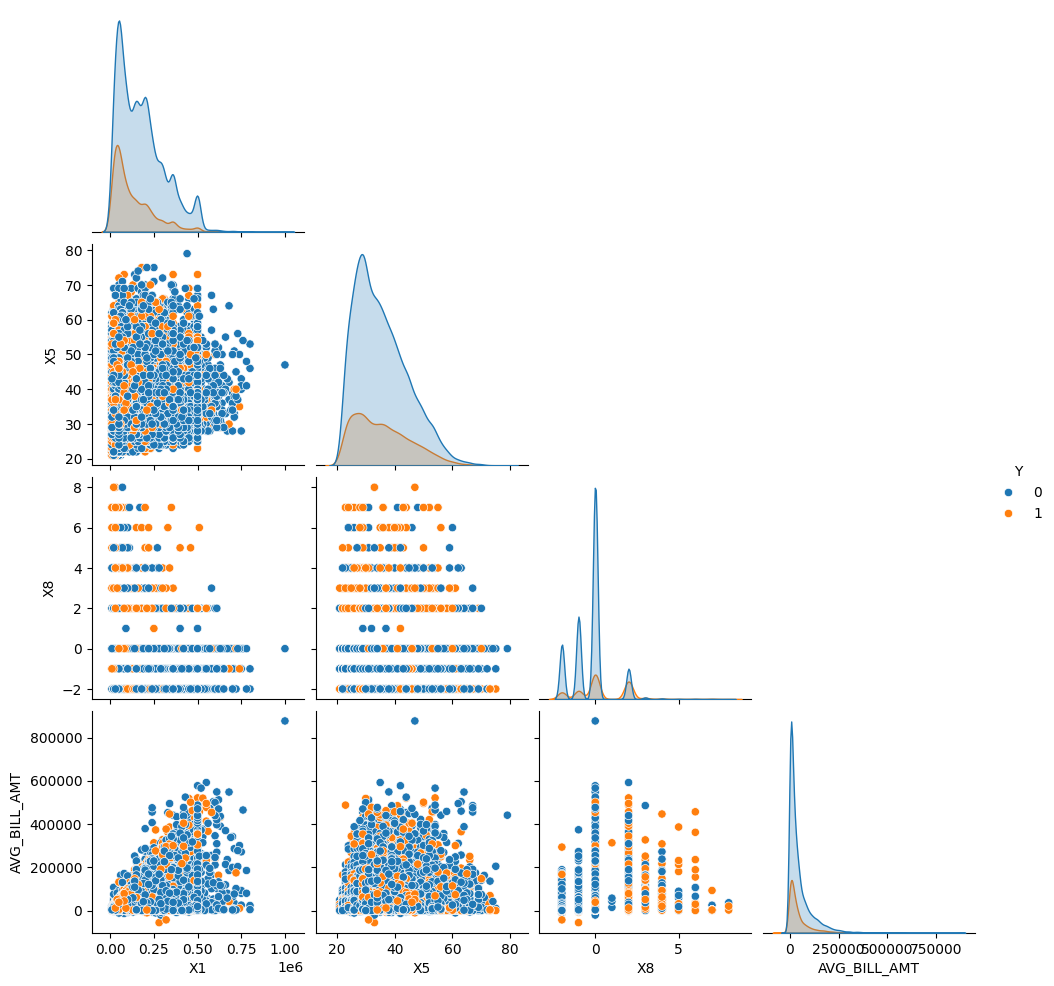

In [12]:
pairplot_features = [
    "X1",            # credit limit
    "X5",            # age
    "X8",            # recent repayment status
    "AVG_BILL_AMT",  # aggregated bill amount
    "Y"              # target
]

sns.pairplot(
    df_reduced[pairplot_features],
    hue="Y",
    diag_kind="kde",
    corner=True
)

plt.show()


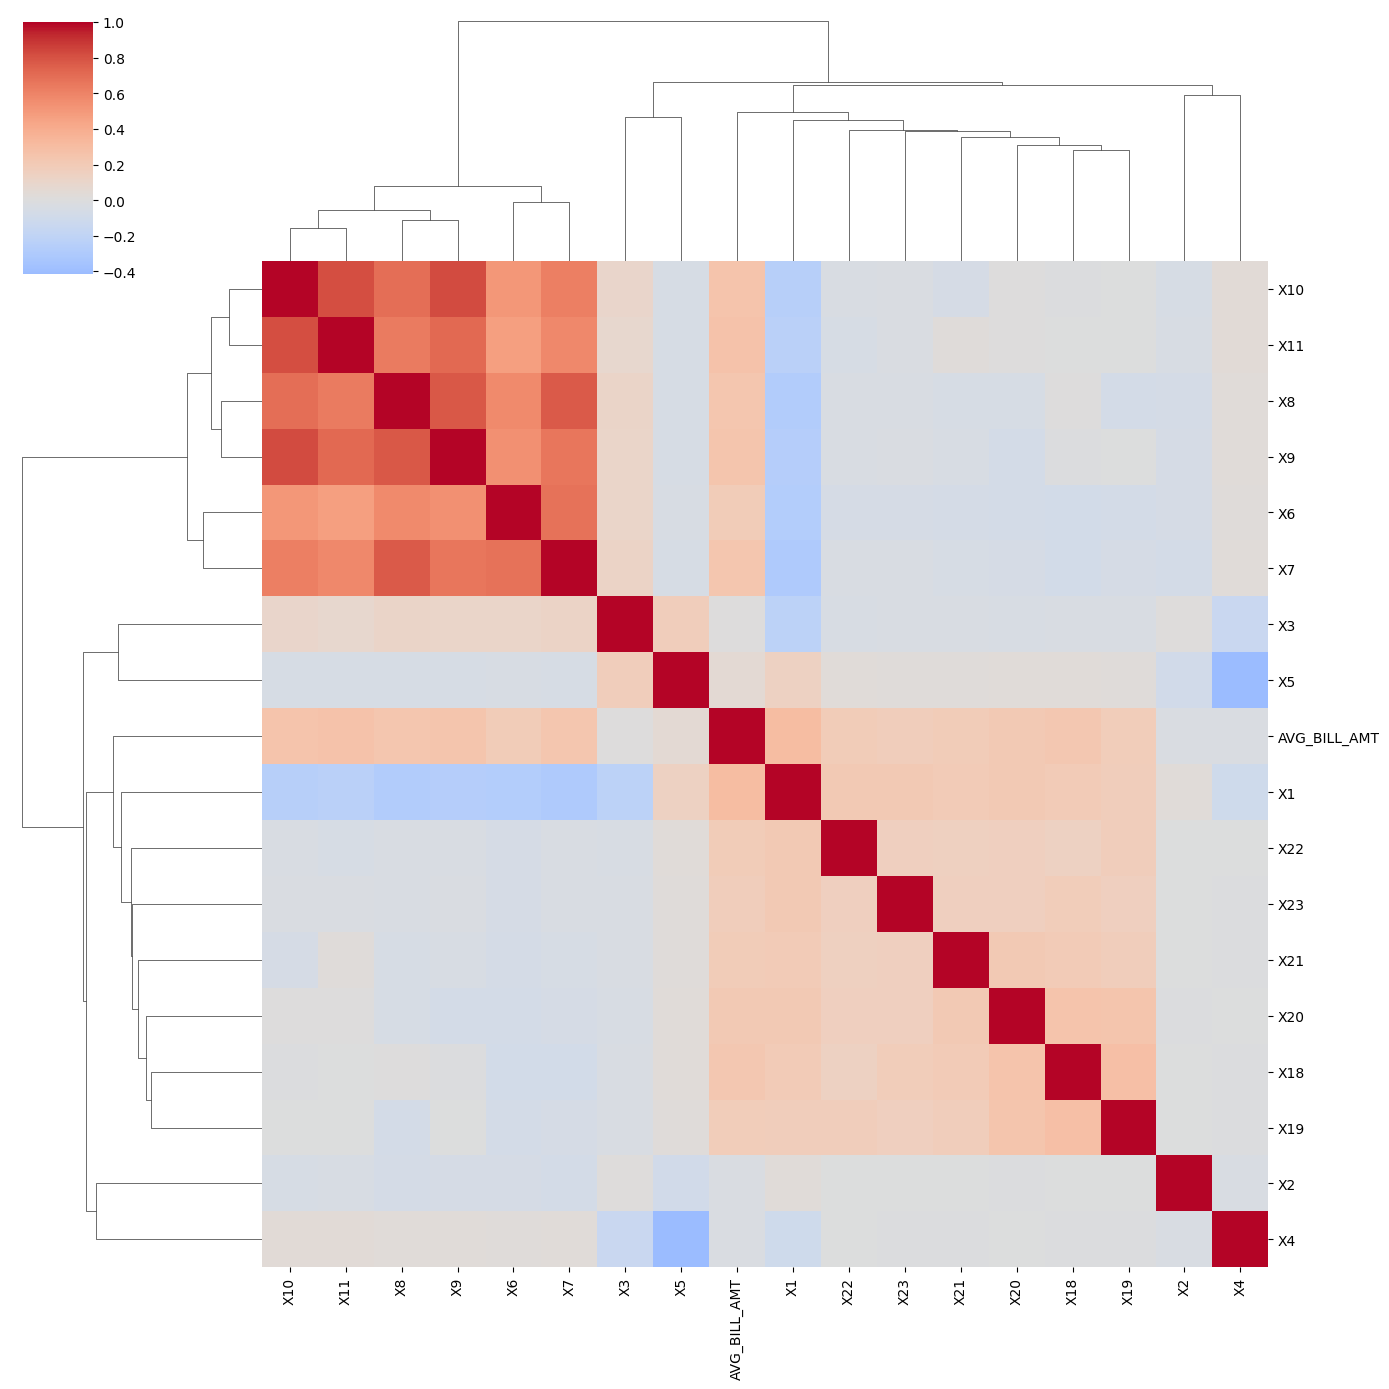

In [13]:
# compute correlation matrix
corr_matrix = df_reduced.drop(columns=["Y"]).corr()

# clustered heatmap
sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    figsize=(14, 14)
)

plt.show()


In [14]:
# features / target
X_all = df_reduced.drop(columns=["Y"]).copy()
y_all = df_reduced["Y"].astype(int).values.reshape(-1, 1)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# standardize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# add intercept column of 1s
X_train_s = np.hstack([np.ones((X_train_s.shape[0], 1)), X_train_s])
X_test_s  = np.hstack([np.ones((X_test_s.shape[0], 1)),  X_test_s])


In [15]:
class LogisticRegression:
    def __init__(self, lr=0.1, n_iters=1000, reg_lambda=0.0, method="batch",
                 batch_size=64, shuffle=True, random_state=42):
        """
        method: 'batch' | 'sgd' | 'minibatch'
        """
        self.lr = lr
        self.n_iters = n_iters
        self.reg_lambda = reg_lambda
        self.method = method
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.w = None
        self.loss_history = []

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        n = X.shape[0]
        p = self._sigmoid(X @ self.w)

        eps = 1e-12
        p = np.clip(p, eps, 1 - eps)

        nll = -(y.T @ np.log(p) + (1 - y).T @ np.log(1 - p)) / n
        nll = nll.item()

        if self.reg_lambda > 0:
            nll += (self.reg_lambda / (2 * n)) * np.sum(self.w[1:] ** 2)

        return nll


    def _gradient(self, X, y):
        """
        Vectorized gradient of NLL + L2 penalty (excluding bias).
        """
        n = X.shape[0]
        p = self._sigmoid(X @ self.w)
        grad = (X.T @ (p - y)) / n

        if self.reg_lambda > 0:
            reg = (self.reg_lambda / n) * self.w
            reg[0] = 0.0
            grad = grad + reg
        return grad

    def fit(self, X, y, log_every=50):
        np.random.seed(self.random_state)
        n, d = X.shape
        self.w = np.zeros((d, 1))
        self.loss_history = []

        if self.method == "batch":
            for t in range(1, self.n_iters + 1):
                grad = self._gradient(X, y)
                self.w -= self.lr * grad

                if t % log_every == 0 or t == 1:
                    self.loss_history.append(self._loss(X, y))

        elif self.method in ["sgd", "minibatch"]:
            idx = np.arange(n)
            bs = 1 if self.method == "sgd" else int(self.batch_size)

            for epoch in range(1, self.n_iters + 1):
                if self.shuffle:
                    np.random.shuffle(idx)

                for start in range(0, n, bs):
                    batch_idx = idx[start:start+bs]
                    Xb, yb = X[batch_idx], y[batch_idx]
                    grad = self._gradient(Xb, yb)
                    self.w -= self.lr * grad

                if epoch % log_every == 0 or epoch == 1:
                    self.loss_history.append(self._loss(X, y))

        else:
            raise ValueError("method must be 'batch', 'sgd', or 'minibatch'")

        return self

    def predict_proba(self, X):
        return self._sigmoid(X @ self.w)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [16]:
def evaluate(model, X_te, y_te):
    probs = model.predict_proba(X_te)
    preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds),
        "recall": recall_score(y_te, preds),
        "f1": f1_score(y_te, preds),
        "auc": roc_auc_score(y_te, probs),
    }

batch = LogisticRegression(lr=0.1, n_iters=800, reg_lambda=0.0, method="batch")
sgd   = LogisticRegression(lr=0.01, n_iters=40, reg_lambda=0.0, method="sgd")
mbgd  = LogisticRegression(lr=0.05, n_iters=80, reg_lambda=0.0, method="minibatch", batch_size=256)

batch.fit(X_train_s, y_train, log_every=20)
sgd.fit(X_train_s, y_train, log_every=5)
mbgd.fit(X_train_s, y_train, log_every=10)


In [17]:

results = pd.DataFrame({
    "Batch GD": evaluate(batch, X_test_s, y_test),
    "SGD": evaluate(sgd, X_test_s, y_test),
    "Mini-batch GD": evaluate(mbgd, X_test_s, y_test),
}).T

results = results[["accuracy", "precision", "recall", "f1", "auc"]].round(4)

results




,accuracy,precision,recall,f1,auc
Batch GD,0.8075,0.6878,0.2374,0.3529,0.7058
SGD,0.8077,0.6570,0.2728,0.3855,0.6892
Mini-batch GD,0.8068,0.6826,0.2366,0.3514,0.7058


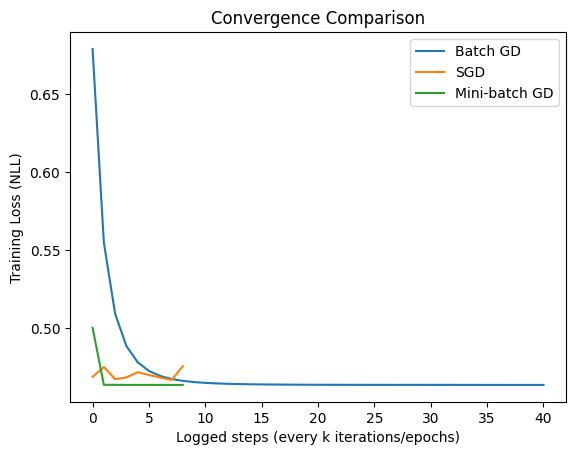

In [18]:

plt.figure()
plt.plot(batch.loss_history, label="Batch GD")
plt.plot(sgd.loss_history, label="SGD")
plt.plot(mbgd.loss_history, label="Mini-batch GD")
plt.xlabel("Logged steps (every k iterations/epochs)")
plt.ylabel("Training Loss (NLL)")
plt.legend()
plt.title("Convergence Comparison")
plt.show()

### Gradient Descent Variants

We compared three optimization strategies:

1. **Batch Gradient Descent**  
   Batch GD computes the gradient using the entire training dataset at each iteration. As shown in the convergence plot, Batch GD exhibits a smooth and stable decrease in training loss and converges reliably to a minimum. However, each update is computationally expensive, making it less scalable to large datasets.

2. **Stochastic Gradient Descent**  
   SGD updates parameters using one data point at a time. The convergence curve shows noticeable noise due to high variance in gradient estimates. Despite this, SGD reaches a reasonable solution quickly and can escape shallow local minima, though it may oscillate near the optimum.

3. **Mini-batch Gradient Descent**  
   Mini-batch GD strikes a balance between Batch GD and SGD by using small batches of data. Its convergence curve is smoother than SGD and faster than Batch GD. In practice, it provides a good trade-off between convergence stability and computational efficiency.


### Convergence Comparison
The convergence plot demonstrates:
- Batch GD converges smoothly but more slowly.
- SGD converges faster initially but with high variance.
- Mini-batch GD achieves stable and efficient convergence.

These behaviors align with theoretical expectations discussed in class and in the literature on stochastic optimization.


### Performance Comparison
All three methods achieve similar accuracy and ROC-AUC scores on the test set. Minor differences in precision and recall are attributable to the stochasticity of SGD-based methods and the imbalanced nature of the dataset. Overall, Mini-batch GD provides the best balance between convergence speed and stability for this task.


In [19]:
class LogisticRegressionOpt:
    def __init__(
        self,
        lr=0.01,
        n_iters=50,          
        reg_lambda=0.0,         
        method="minibatch",     
        batch_size=256,
        shuffle=True,
        random_state=42,
        optimizer="sgd",        
        beta=0.9,                
        beta2=0.999,             
        eps=1e-8              
    ):
        self.lr = lr
        self.n_iters = n_iters
        self.reg_lambda = reg_lambda
        self.method = method
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state

        self.optimizer = optimizer
        self.beta = beta
        self.beta2 = beta2
        self.eps = eps

        self.w = None
        self.loss_history = []

        self.v = None     # momentum / Adam first moment
        self.s = None     # RMSProp cache / Adam second moment
        self.t = 0        # Adam timestep

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        n = X.shape[0]
        p = self._sigmoid(X @ self.w)
        p = np.clip(p, 1e-12, 1 - 1e-12)
        nll = -(y.T @ np.log(p) + (1 - y).T @ np.log(1 - p)) / n
        nll = nll.item()

        if self.reg_lambda > 0:
            nll += (self.reg_lambda / (2 * n)) * np.sum(self.w[1:] ** 2)
        return nll

    def _gradient(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        n = X.shape[0]
        p = self._sigmoid(X @ self.w)
        grad = (X.T @ (p - y)) / n

        if self.reg_lambda > 0:
            reg = (self.reg_lambda / n) * self.w
            reg[0] = 0.0
            grad = grad + reg
        return grad

    def _apply_update(self, grad):
        if self.optimizer == "sgd":
            self.w -= self.lr * grad
            return

        # momentum
        if self.optimizer == "momentum":
            if self.v is None:
                self.v = np.zeros_like(self.w)
            self.v = self.beta * self.v + (1 - self.beta) * grad
            self.w -= self.lr * self.v
            return

        # RMSProp
        if self.optimizer == "rmsprop":
            if self.s is None:
                self.s = np.zeros_like(self.w)
            self.s = self.beta * self.s + (1 - self.beta) * (grad ** 2)
            self.w -= self.lr * grad / (np.sqrt(self.s) + self.eps)
            return

        # Adam
        if self.optimizer == "adam":
            if self.v is None:
                self.v = np.zeros_like(self.w)
            if self.s is None:
                self.s = np.zeros_like(self.w)

            self.t += 1
            self.v = self.beta * self.v + (1 - self.beta) * grad
            self.s = self.beta2 * self.s + (1 - self.beta2) * (grad ** 2)

            v_hat = self.v / (1 - self.beta ** self.t)
            s_hat = self.s / (1 - self.beta2 ** self.t)

            self.w -= self.lr * v_hat / (np.sqrt(s_hat) + self.eps)
            return

        raise ValueError("optimizer must be: sgd, momentum, rmsprop, adam")

    def fit(self, X, y, log_every=10):
        np.random.seed(self.random_state)
        n, d = X.shape
        self.w = np.zeros((d, 1))
        self.loss_history = []
        self.v = None
        self.s = None
        self.t = 0

        if self.method == "batch":
            for it in range(1, self.n_iters + 1):
                grad = self._gradient(X, y)
                self._apply_update(grad)

                if it % log_every == 0 or it == 1:
                    self.loss_history.append(self._loss(X, y))
            return self

        # SGD or Mini-batch
        idx = np.arange(n)
        bs = 1 if self.method == "sgd" else int(self.batch_size)

        for epoch in range(1, self.n_iters + 1):
            if self.shuffle:
                np.random.shuffle(idx)

            for start in range(0, n, bs):
                batch_idx = idx[start:start+bs]
                Xb, yb = X[batch_idx], y[batch_idx]
                grad = self._gradient(Xb, yb)
                self._apply_update(grad)

            if epoch % log_every == 0 or epoch == 1:
                self.loss_history.append(self._loss(X, y))

        return self

    def predict_proba(self, X):
        return self._sigmoid(X @ self.w)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)



### Optimizers implemented
- **SGD (baseline):** standard parameter update using the (stochastic/mini-batch) gradient.
- **Momentum:** accumulates a velocity term (exponentially weighted moving average of gradients) to reduce oscillations and speed convergence (Polyak, 1964).
- **RMSProp:** adapts step sizes per-parameter using a running average of squared gradients (Tieleman & Hinton, 2012).
- **Adam:** combines momentum-like first-moment estimation with RMSProp-like second-moment adaptation and bias correction (Kingma & Ba, 2015). 

### What we compare
1. **Convergence behavior** using the training negative log-likelihood (cross-entropy) loss curves.
2. **Test-set performance** using accuracy, precision, recall, F1, and ROC-AUC.
3. **Hyperparameter tuning impact** (learning rate and optimizer-specific parameters) using a validation set (to avoid test leakage).

### References
- Kingma, D. P., & Ba, J. (2015). *Adam: A Method for Stochastic Optimization*.
- Polyak, B. T. (1964). *Some methods of speeding up the convergence of iteration methods*.
- Tieleman, T., & Hinton, G. (2012). *RMSProp (lecture notes)*.

In [20]:
def evaluate_metrics(model, X_te, y_te):
    y_te = y_te.reshape(-1, 1)
    probs = model.predict_proba(X_te)
    preds = (probs >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds, zero_division=0),
        "recall": recall_score(y_te, preds, zero_division=0),
        "f1": f1_score(y_te, preds, zero_division=0),
        "auc": roc_auc_score(y_te, probs),
    }

def train_one(optimizer, lr, method="minibatch", batch_size=256, n_iters=60, beta=0.9, beta2=0.999):
    model = LogisticRegressionOpt(
        lr=lr,
        n_iters=n_iters,
        method=method,
        batch_size=batch_size,
        optimizer=optimizer,
        beta=beta,
        beta2=beta2,
        reg_lambda=0.0
    )
    model.fit(X_train_s, y_train, log_every=5)
    return model

models = {
    "SGD": train_one("sgd", lr=0.05),
    "Momentum": train_one("momentum", lr=0.05, beta=0.9),
    "RMSProp": train_one("rmsprop", lr=0.01, beta=0.9),
    "Adam": train_one("adam", lr=0.01, beta=0.9, beta2=0.999),
}

results = pd.DataFrame({name: evaluate_metrics(m, X_test_s, y_test) for name, m in models.items()}).T
results = results[["accuracy", "precision", "recall", "f1", "auc"]].round(4)
results



,accuracy,precision,recall,f1,auc
SGD,0.8073,0.6863,0.2374,0.3527,0.7058
Momentum,0.8075,0.6822,0.2427,0.3580,0.7056
RMSProp,0.8087,0.6941,0.2411,0.3579,0.7073
Adam,0.8070,0.7195,0.2087,0.3236,0.7039


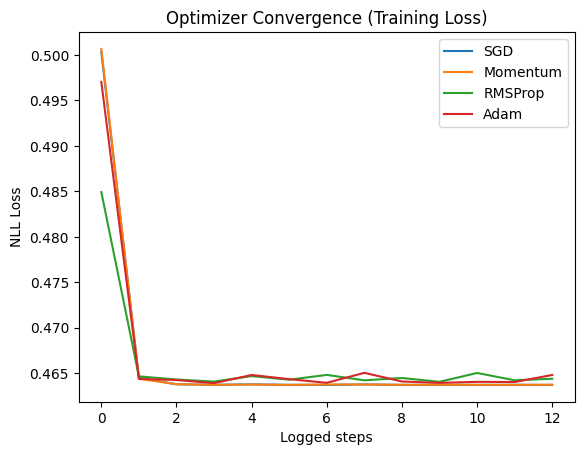

In [21]:

plt.figure()
for name, m in models.items():
    plt.plot(m.loss_history, label=name)

plt.title("Optimizer Convergence (Training Loss)")
plt.xlabel("Logged steps")
plt.ylabel("NLL Loss")
plt.legend()
plt.show()

In [22]:
def grid_search(optimizer, lr_list, beta_list=None, beta2_list=None, n_iters=60):
    rows = []
    beta_list = beta_list or [0.9]
    beta2_list = beta2_list or [0.999]

    for lr in lr_list:
        for beta in beta_list:
            for beta2 in beta2_list:
                m = LogisticRegressionOpt(
                    lr=lr, n_iters=n_iters,
                    method="minibatch", batch_size=256,
                    optimizer=optimizer,
                    beta=beta, beta2=beta2,
                    reg_lambda=0.0
                )
                m.fit(X_train_s, y_train, log_every=10)
                met = evaluate_metrics(m, X_test_s, y_test)
                rows.append({
                    "optimizer": optimizer,
                    "lr": lr,
                    "beta": beta,
                    "beta2": beta2,
                    **met
                })
    out = pd.DataFrame(rows).sort_values(by="auc", ascending=False)
    return out

sgd_grid = grid_search("sgd", lr_list=[0.1, 0.05, 0.01], n_iters=60)
mom_grid = grid_search("momentum", lr_list=[0.1, 0.05, 0.01], beta_list=[0.8, 0.9, 0.95], n_iters=60)
rms_grid = grid_search("rmsprop", lr_list=[0.01, 0.005, 0.001], beta_list=[0.9, 0.95], n_iters=60)
adam_grid = grid_search("adam", lr_list=[0.01, 0.005, 0.001], beta_list=[0.9, 0.95], beta2_list=[0.999, 0.99], n_iters=60)

sgd_grid.head(5), mom_grid.head(5), rms_grid.head(5), adam_grid.head(5)


(  optimizer    lr  beta  beta2  accuracy  precision    recall        f1  \
 0       sgd  0.10   0.9  0.999  0.808000   0.692308  0.237378  0.353535   
 1       sgd  0.05   0.9  0.999  0.807333   0.686275  0.237378  0.352744   
 2       sgd  0.01   0.9  0.999  0.806833   0.683406  0.235870  0.350700   
 
         auc  
 0  0.705849  
 1  0.705846  
 2  0.705760  ,
   optimizer    lr  beta  beta2  accuracy  precision    recall        f1  \
 8  momentum  0.01  0.95  0.999  0.807000   0.684096  0.236624  0.351624   
 6  momentum  0.01  0.80  0.999  0.806833   0.683406  0.235870  0.350700   
 7  momentum  0.01  0.90  0.999  0.806833   0.682609  0.236624  0.351427   
 3  momentum  0.05  0.80  0.999  0.807500   0.686957  0.238131  0.353665   
 0  momentum  0.10  0.80  0.999  0.807500   0.691111  0.234363  0.350028   
 
         auc  
 8  0.705762  
 6  0.705750  
 7  0.705749  
 3  0.705726  
 0  0.705634  ,
   optimizer     lr  beta  beta2  accuracy  precision    recall        f1  \
 2   rm

In [23]:
best_val = pd.concat(
    [
        sgd_grid.head(1),
        mom_grid.head(1),
        rms_grid.head(1),
        adam_grid.head(1),
    ],
    ignore_index=True
)

best_val[["optimizer","lr","beta","beta2","accuracy","precision","recall","f1","auc"]].round(4)


,optimizer,lr,beta,beta2,accuracy,precision,recall,f1,auc
0,sgd,0.100,0.90,0.999,0.8080,0.6923,0.2374,0.3535,0.7058
1,momentum,0.010,0.95,0.999,0.8070,0.6841,0.2366,0.3516,0.7058
2,rmsprop,0.005,0.90,0.999,0.8083,0.6945,0.2381,0.3547,0.7076
3,adam,0.001,0.95,0.990,0.8073,0.6815,0.2419,0.3571,0.7058


In [24]:
def retrain_best_and_test(best_row, n_iters=80):
    opt = best_row["optimizer"]
    lr = float(best_row["lr"])
    beta = float(best_row.get("beta", 0.9))
    beta2 = float(best_row.get("beta2", 0.999))

    m = LogisticRegressionOpt(
        lr=lr,
        n_iters=n_iters,
        method="minibatch",
        batch_size=256,
        optimizer=opt,
        beta=beta,
        beta2=beta2,
        reg_lambda=0.0
    )
    # retrain on full training set (X_train_s, y_train)
    m.fit(X_train_s, y_train, log_every=10)
    return m

final_models = {}
for _, row in best_val.iterrows():
    final_models[row["optimizer"].upper()] = retrain_best_and_test(row, n_iters=80)

test_results = pd.DataFrame({name: evaluate_metrics(m, X_test_s, y_test) for name, m in final_models.items()}).T
test_results = test_results[["accuracy","precision","recall","f1","auc"]].round(4)
test_results


,accuracy,precision,recall,f1,auc
SGD,0.8070,0.6825,0.2381,0.3531,0.7057
MOMENTUM,0.8072,0.6848,0.2374,0.3525,0.7058
RMSPROP,0.8068,0.6750,0.2442,0.3586,0.7069
ADAM,0.8072,0.6856,0.2366,0.3518,0.7059


In [25]:
test_results.round(4)


,accuracy,precision,recall,f1,auc
SGD,0.8070,0.6825,0.2381,0.3531,0.7057
MOMENTUM,0.8072,0.6848,0.2374,0.3525,0.7058
RMSPROP,0.8068,0.6750,0.2442,0.3586,0.7069
ADAM,0.8072,0.6856,0.2366,0.3518,0.7059


All four optimizers achieve very similar accuracy (around 0.807) and ROC-AUC (around 0.706), which is expected since logistic regression has a convex objective and all methods converge to similar solutions.

RMSProp performs slightly better than the other optimizers, achieving the highest recall (0.2442), F1 score (0.3586), and ROC-AUC (0.7069) on both the validation and test sets. This suggests that RMSProp’s adaptive learning rates help the model better capture positive default cases. Momentum and Adam show very similar performance to vanilla SGD, indicating that while they improve convergence stability, they do not significantly change the final predictive performance on this dataset.

The close match between validation and test results indicates that the hyperparameter tuning process did not overfit the validation set. Overall, advanced optimizers mainly improve convergence behavior, but for this logistic regression task, they provide only modest gains in final performance, with RMSProp offering the most consistent improvement.
